In [1]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask                        2.3.2
flatbuf

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [4]:
# 2. Remove dodgy images
import cv2
import imghdr
data_dir = 'ISIC/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

C:\Users\ADEBOSS\AppData\Local\Temp\ipykernel_4392\3474658621.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Found 1043 files belonging to 3 classes.


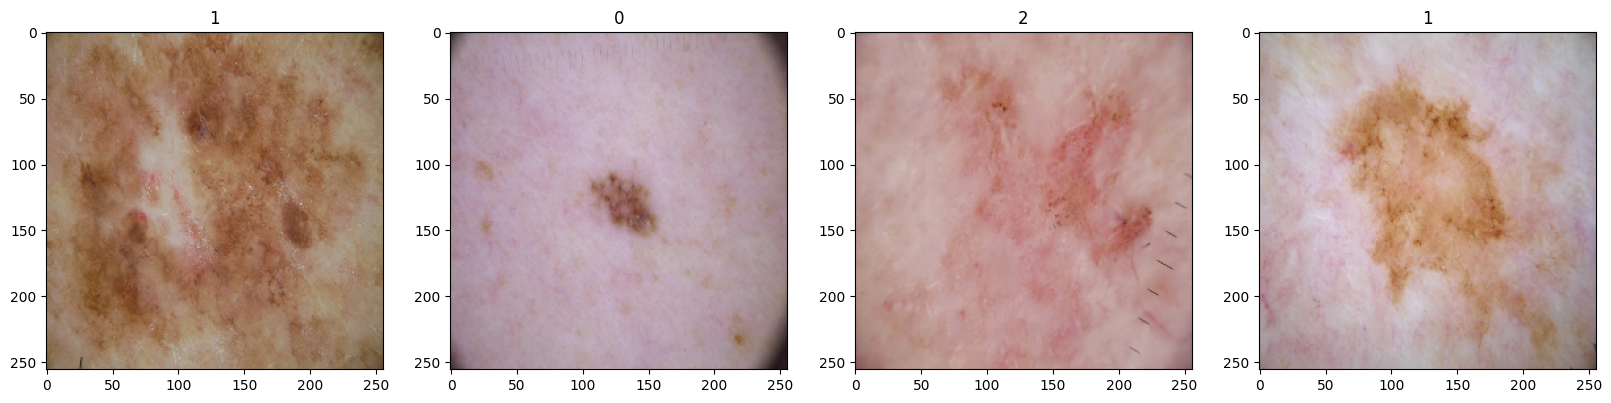

In [5]:
# 3. Load Data
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('ISIC/train', labels='inferred', label_mode='int')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [6]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.7348937 , 0.546408  , 0.57073665],
          [0.73387593, 0.54891187, 0.56220055],
          [0.72000825, 0.53607535, 0.5553768 ],
          ...,
          [0.6951112 , 0.5704176 , 0.58443195],
          [0.70047486, 0.5646678 , 0.5758964 ],
          [0.6897571 , 0.5561248 , 0.5643282 ]],
 
         [[0.72847086, 0.540916  , 0.5580121 ],
          [0.7255515 , 0.53339463, 0.5490809 ],
          [0.72427285, 0.53250134, 0.55603075],
          ...,
          [0.70025635, 0.5759828 , 0.59559065],
          [0.6991644 , 0.56471425, 0.5693642 ],
          [0.6963453 , 0.55552906, 0.56864184]],
 
         [[0.7170518 , 0.5201811 , 0.5407978 ],
          [0.7185904 , 0.52643347, 0.54211974],
          [0.7260201 , 0.53416055, 0.55768996],
          ...,
          [0.71079963, 0.5888174 , 0.6189491 ],
          [0.69897604, 0.57189274, 0.5834341 ],
          [0.7101761 , 0.57623863, 0.5952163 ]],
 
         ...,
 
         [[0.75318414, 0.6145003 , 0.63018656],
          [0.74948

In [7]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [8]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 4 output classes
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [10]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
23/23 [==============================] - 299s 11s/step - loss: 1.7034 - accuracy: 0.4565 - val_loss: 0.8519 - val_accuracy: 0.6615
Epoch 2/30
23/23 [==============================] - 138s 6s/step - loss: 0.7806 - accuracy: 0.6685 - val_loss: 0.7440 - val_accuracy: 0.6927
Epoch 3/30
23/23 [==============================] - 106s 4s/step - loss: 0.7333 - accuracy: 0.6929 - val_loss: 0.6428 - val_accuracy: 0.6927
Epoch 4/30
23/23 [==============================] - 127s 5s/step - loss: 0.6304 - accuracy: 0.7323 - val_loss: 0.5971 - val_accuracy: 0.7135
Epoch 5/30
23/23 [==============================] - 124s 5s/step - loss: 0.7059 - accuracy: 0.7160 - val_loss: 0.6608 - val_accuracy: 0.7448
Epoch 6/30
23/23 [==============================] - 106s 4s/step - loss: 0.6065 - accuracy: 0.7473 - val_loss: 0.6317 - val_accuracy: 0.7188
Epoch 7/30
23/23 [==============================] - 87s 4s/step - loss: 0.5664 - accuracy: 0.7636 - val_loss: 0.5605 - val_accuracy: 0.7344
Epoch 8/30
23

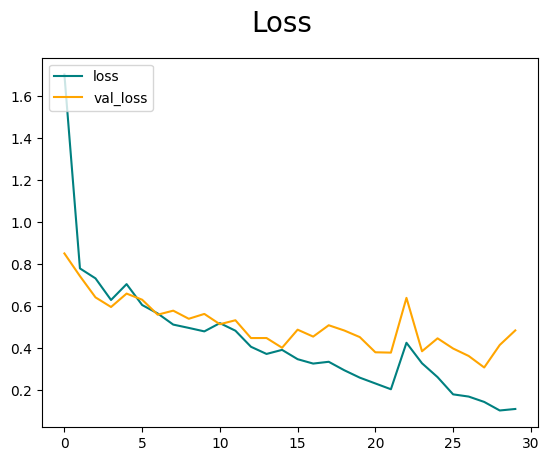

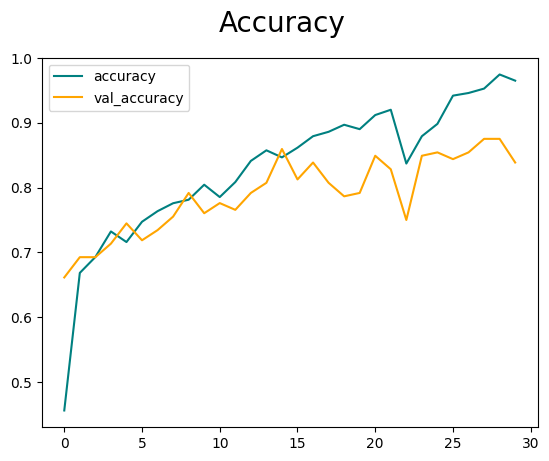

In [11]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 2s 2s/step
tf.Tensor(0.9032258, shape=(), dtype=float32) tf.Tensor(0.9491525, shape=(), dtype=float32) tf.Tensor(0.75, shape=(), dtype=float32)


In [13]:
# 10. Test
import cv2

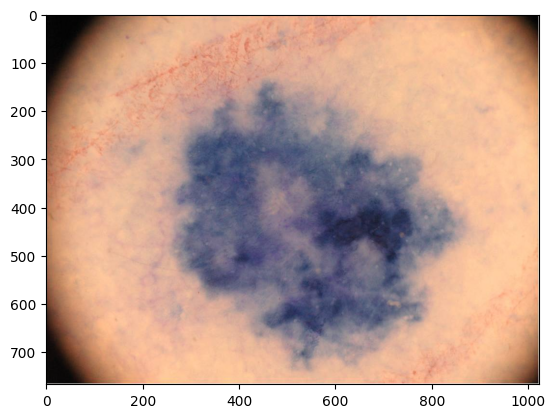

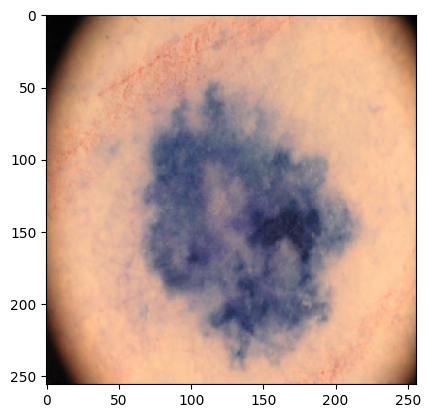

1/1 [==============================] - 0s 88ms/step
Predicted class is a Melanoma


In [16]:
img = cv2.imread('ISIC/TraiN/melanoma/ISIC_0000002.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = np.argmax(yhat)  # Get the index of the highest probability class
classes = ['Basal cell Carcinoma', 'Melanoma', 'Squamous cell carcinoma']
print(f'Predicted class is a {classes[predicted_class]}')

In [15]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifier.h5'))
new_model = load_model('models/imageclassifier.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 1s 784ms/step


array([[0.89011127, 0.101967  , 0.00792173]], dtype=float32)